In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Google Storage**

In [ ]:
! pip install cloud-tpu-client
! pip install transformers         #HuggingFace transformer library  https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html
! pip install bert-for-tf2 
! pip install tensorflow_addons  #AdaW
! pip install tf-models-official   # by Google inc --> AdamW optimizer for BERT with learning rate  linear decay scheduel

**Example of Google translate**

In [ ]:
#Tesorflow TPU and Cloab versions should be the same
import tensorflow as tf
print (tf.__version__)
tf.get_logger().setLevel('ERROR')
from cloud_tpu_client import Client
Client().configure_tpu_version(tf.__version__, restart_type='ifNeeded')

2.4.1


In [ ]:
import os 
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
import locale
from time import time
import datetime
import gc
import unicodedata 
import math
import random
import pprint

import numpy as np
import pandas as pd

In [ ]:
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  
  tpu_address = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
  print ('TPU address is', tpu_address)
  
  with tf.compat.v1.Session(tpu_address) as session:
    devices = session.list_devices()
  
  print('TPU devices:')
  pprint.pprint(devices)

else:
  tpu_address=''

TPU address is grpc://10.34.17.210:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, -706252230177110526),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 5946209155648704248),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 404721471314434568),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, -6611025134357406597),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3782173974083013653),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8754792443888082667),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 5949256028562783023),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, -5222211776635992546),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, -2

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as KBEND
import tensorflow_addons as tfa

from tensorflow.python.keras.utils.data_utils import Sequence, is_generator_or_sequence

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#https://www.tensorflow.org/tutorials/text/classify_text_with_bert
from official.nlp import optimization  # to create AdamW optmizer

In [ ]:
from bert import bert_tokenization # this is bert for tensorflow2.  Use this just for the tokenizer
from transformers import TFBertModel, BertConfig  # Use the BERT implementation from HuggingFace; now available for TF2 (https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel)

In [ ]:
import re  # regular expressions
import pickle
#from stop_words import get_stop_words

import nltk
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
nltk.download('punkt')
#from nltk.corpus import stopwords

from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.metrics import confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import gridspec  #https://matplotlib.org/users/gridspec.html
from matplotlib.ticker import FuncFormatter #https://matplotlib.org/examples/pylab_examples/histogram_percent_demo.html

from IPython.display import display
from ipywidgets import FloatProgress

#Windows
#prefix = 'E:'
#Linux
#prefix = '/media/kyazigee/Samsung_T5_PC'
#Google drive
prefix = 'drive/MyDrive'

data_dir = prefix + '/WORK/HCI/AirBank/TVT/'
data_dir_tokenized = prefix + '/WORK/HCI/AirBank/TVT/TokenizedTrainTest/'
BERT_dir = prefix + '/WORK/HCI/AirBank/TVT/BERT/'
DCNN_dir = prefix + '/WORK/HCI/AirBank/TVT/DCNN/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**UTILS**

In [ ]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print ('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end ='\r'), 
    # Print New Line on Complete
    if iteration == total: 
        print('\n')        

**LOAD DATA**

In [ ]:
col_target = 'LEVEL_2_ENCODED'
col_weight = 'WT'

In [ ]:
from sklearn.model_selection import  train_test_split

MISSING_VALUES = ['-','.']
_unicode = {}
DATES = []

source = 'messages' 
messages =  pd.read_csv(data_dir + source + ".csv", encoding = 'utf-8'  ,na_values = MISSING_VALUES, decimal = '.', sep = ',' 
                  ,  dayfirst = True, parse_dates = DATES,  dtype= _unicode , engine='python')

mask = pd.isnull(messages['PREDMET'])
messages.loc[mask , 'PREDMET'] = ''

mask = pd.isnull(messages['TEXT_KOMUNIKACE'])
messages.loc[mask , 'TEXT_KOMUNIKACE'] = ''

mask = pd.isnull(messages['TEXT_KOMUNIKACE_CLEAN'])
messages.loc[mask , 'TEXT_KOMUNIKACE_CLEAN'] = ''

mask = pd.isnull(messages['PREDMET_CLEAN'])
messages.loc[mask , 'PREDMET_CLEAN'] = ''

#drop duplicates (Lubor)
#------------------------

subset_cols = ['PREDMET', 'LEVEL_1', 'LEVEL_2', 'TEXT_KOMUNIKACE']
messages= messages.drop_duplicates(subset = subset_cols,ignore_index=True)


#clean (Lubor): #Keeping text wit appl rating only to cats 13 and 14
#----------------------

def is_aplikace(row):
    return int('plikace My Air' in row)

messages['is_appka'] = messages['PREDMET'].apply(is_aplikace)
contacts = messages[((((messages[col_target] != 13) & (messages[col_target] != 14))) & (messages['is_appka'] == 1))]['SKP_CONTACT'].tolist()
messages = messages[~messages['SKP_CONTACT'].isin(contacts)].reset_index(drop = True)

#---------------------
messages['is_re'] = messages['PREDMET'].apply(lambda x: int('re: ' in x.lower()))

messages['JOINT_CLEAN'] = messages['PREDMET_CLEAN'] + ' ' + messages['TEXT_KOMUNIKACE_CLEAN']

messages['tokens_PREDMET'] = messages['PREDMET_CLEAN'].apply(lambda x: word_tokenize(x) )
messages['tokens_TEXT'] = messages['TEXT_KOMUNIKACE_CLEAN'].apply(lambda x: word_tokenize(x) )

messages['tokens_joint'] = messages['tokens_PREDMET'] + messages['tokens_TEXT']

messages['len_PREDMET'] = messages['tokens_PREDMET'].apply(lambda x : len(x))
messages['len_TEXT'] = messages['tokens_TEXT'].apply(lambda x : len(x))

messages['EMAIL'] = 0
messages.loc[ messages['KANAL'] == 'Email', 'EMAIL'] = 1
messages['IB'] = 0
messages.loc[ messages['KANAL'] == 'IB', 'IB'] = 1

mask = messages['type'] == 'train_valid'
                
A , B = train_test_split( messages[mask], test_size = 0.3333, random_state = 42,\
                                stratify = messages[mask][col_target] )

messages.loc[A.index, 'type'] = 'train'
messages.loc[B.index, 'type'] = 'valid'

del A,B, mask


#---------[Override target]------------#

LABELS = messages['LEVEL_2'].value_counts().index.tolist()
OTHER = ['1/H - Kanály']
#OTHER += ['Něco nefunguje','3. strany', 'Bankovní kontakty', 'Pochvaly']
#OTHER += ['Reakce na naši komunikaci', 'Změny údajů','Podněty']


PRODS = set(LABELS)- set(OTHER)

base_mask = messages['LEVEL_2'].isin(PRODS)

messages = messages[base_mask]
#messages.sort_values(by =['SKP_CONTACT'], ascending=[True], na_position = 'first',inplace=True)
#messages['technical_id'] = messages.index
messages = messages.reset_index(drop = True)

#[]
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(messages['LEVEL_2'])

print ('target encodings:')
for i in set(y):
    print(i, encoder.inverse_transform([i]))
    
with open(DCNN_dir + "label_encoder", "wb") as f:
            pickle.dump(encoder, f)

#[]
keep = ['SKP_CONTACT' ,'LEVEL_2','EMAIL','IB','PREDMET_CLEAN', 'len_PREDMET', 'TEXT_KOMUNIKACE_CLEAN','len_TEXT' ,\
        'type', 'tokens_PREDMET',\
        'tokens_TEXT' , 'JOINT_CLEAN', 'tokens_joint', 'is_appka', 'is_re','WT'] 
messages = pd.concat( [ messages [keep]  , pd.DataFrame(y)[0] ] , axis =1)
messages.rename( columns = {0: 'LEVEL_2_ENCODED'}, inplace = True)
#-----------------------------------#

target encodings:
0 ['1/A - Platby ']
1 ['1/B - Karta + nálepka ']
2 ['1/C - Půjčka']
3 ['1/D - IB + MA']
4 ['1/E - BÚ + SÚ']
5 ['1/F - Pojištění ']
6 ['1/G - Hypotéka ']
7 ['1/K - Odměny']
8 ['1/L - Kontokorent']
9 ['1/M - Investice + penzijní spoření']
10 ['3. strany']
11 ['Bankovní kontakty']
12 ['Něco nefunguje']
13 ['Pochvaly']
14 ['Podněty']
15 ['Reakce na naši komunikaci']
16 ['Změny údajů']


In [ ]:
messages['is_re'].value_counts()

0    81732
1    36264
Name: is_re, dtype: int64

In [ ]:
print(messages['TEXT_KOMUNIKACE_CLEAN'][5])
print(messages['tokens_joint'][5])

na manželčině účtu ke kterému mám dispoziční právo jsem objevil nezvyklou výši úroku za prosinec Kč reference úhrady Chtěl bych se zeptat jak taková výše úroku může vzniknout že by příprava na záporné úročení Předem díky za odpověď a do nového roku vám přeji vše nej S pozdravem
['Dotaz', 'na', 'výši', 'úroku', 'na', 'manželčině', 'účtu', 'ke', 'kterému', 'mám', 'dispoziční', 'právo', 'jsem', 'objevil', 'nezvyklou', 'výši', 'úroku', 'za', 'prosinec', 'Kč', 'reference', 'úhrady', 'Chtěl', 'bych', 'se', 'zeptat', 'jak', 'taková', 'výše', 'úroku', 'může', 'vzniknout', 'že', 'by', 'příprava', 'na', 'záporné', 'úročení', 'Předem', 'díky', 'za', 'odpověď', 'a', 'do', 'nového', 'roku', 'vám', 'přeji', 'vše', 'nej', 'S', 'pozdravem']


In [ ]:
display(messages.head(1))

,SKP_CONTACT,LEVEL_2,EMAIL,IB,PREDMET_CLEAN,len_PREDMET,TEXT_KOMUNIKACE_CLEAN,len_TEXT,type,tokens_PREDMET,tokens_TEXT,JOINT_CLEAN,tokens_joint,is_appka,is_re,WT,LEVEL_2_ENCODED
0,177078404,1/E - BÚ + SÚ,1,0,Witam,1,Czy Polacy mogą założyć u was konto,7,valid,[Witam],"[Czy, Polacy, mogą, założyć, u, was, konto]",Witam Czy Polacy mogą założyć u was konto,"[Witam, Czy, Polacy, mogą, założyć, u, was, ko...",0,0,1,4


In [ ]:
print(messages.shape)

(117996, 17)


In [ ]:
messages.dtypes

SKP_CONTACT               int64
LEVEL_2                  object
EMAIL                     int64
IB                        int64
PREDMET_CLEAN            object
len_PREDMET               int64
TEXT_KOMUNIKACE_CLEAN    object
len_TEXT                  int64
type                     object
tokens_PREDMET           object
tokens_TEXT              object
JOINT_CLEAN              object
tokens_joint             object
is_appka                  int64
is_re                     int64
WT                        int64
LEVEL_2_ENCODED           int64
dtype: object

In [ ]:
S = messages['LEVEL_2'].value_counts().values.sum()
PCT = messages['LEVEL_2'].value_counts()/S
PCT

1/B - Karta + nálepka                 0.229965
1/E - BÚ + SÚ                         0.149530
1/C - Půjčka                          0.120352
1/A - Platby                          0.113970
1/D - IB + MA                         0.068926
Reakce na naši komunikaci             0.068596
Změny údajů                           0.057536
1/M - Investice + penzijní spoření    0.047366
1/L - Kontokorent                     0.034340
1/K - Odměny                          0.025382
Podněty                               0.022789
1/F - Pojištění                       0.019967
1/G - Hypotéka                        0.014017
Něco nefunguje                        0.009136
3. strany                             0.007577
Bankovní kontakty                     0.005822
Pochvaly                              0.004729
Name: LEVEL_2, dtype: float64

## DEFINE TRAIN AND TEST SETS

In [ ]:
train_mask = (messages['type'] == 'train') | (messages['type'] == 'valid') 
test_mask = (messages['type'] == 'test') 

In [ ]:
#Add balancing weight variable

def make_balanced(df, balancing_var):
    
        B = df[balancing_var].value_counts().values/df[balancing_var].value_counts().values.sum()
        max_PD = B.max()
        B = max_PD/B
        A = df[balancing_var].value_counts().index
    
        C = pd.DataFrame(B,A)
        C = C.reset_index(drop = False)
        C.rename( columns = {'index' : balancing_var,  0 : col_weight}, inplace = True)
        #C[col_weight] = C.apply(lambda row: adjust_weight(row), axis =1)

        df.rename(columns = {col_weight : col_weight + '_old'}, inplace = True)
        df =  pd.merge(df, C , how = 'left', left_on = [balancing_var], right_on = [balancing_var] )
        df = df.reset_index( drop = True)                                          
        
        return df, C  

balancing_var = col_target

In [ ]:
train, _ =  make_balanced(messages[train_mask], balancing_var)
test, _  =  make_balanced(messages[test_mask], balancing_var)

cols = ['SKP_CONTACT','LEVEL_2', 'LEVEL_2_ENCODED', 'PREDMET_CLEAN', 'TEXT_KOMUNIKACE_CLEAN', 'JOINT_CLEAN', 'tokens_joint', 'len_PREDMET', 'len_TEXT', 'is_re', 'EMAIL', 'WT']
train = train[cols]
test = test[cols]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Numeric attributes**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_PREDMET = MinMaxScaler()
scaler_TEXT = MinMaxScaler()

#scaler_PREDMET = StandardScaler()
#scaler_TEXT = StandardScaler()

scaler_PREDMET.fit(train[['len_PREDMET']])

train['len_PREDMET_s'] = scaler_PREDMET.transform (train[['len_PREDMET']])
test['len_PREDMET_s'] = scaler_PREDMET.transform (test[['len_PREDMET']])

scaler_TEXT.fit(train[['len_TEXT']])

train['len_TEXT_s'] = scaler_TEXT.transform (train[['len_TEXT']])
test['len_TEXT_s'] = scaler_TEXT.transform (test[['len_TEXT']])

train_numeric = train[['len_PREDMET_s', 'len_TEXT_s', 'EMAIL', 'is_re']].values
test_numeric  = test[['len_PREDMET_s', 'len_TEXT_s', 'EMAIL', 'is_re']].values

print(train_numeric.shape)
print(test_numeric.shape)

(88826, 4)
(29170, 4)


In [ ]:
MAX_SEQUENCE_LENGTH_JOINT = 200  #same as Lubor

**Pre trained SLAVIC MODEL from HuggingFace**

In [ ]:
BERT_dir = prefix + '/WORK/HCI/AirBank/TVT/BERT/'
modelsFolder = BERT_dir + 'bert-base-bg-cs-pl-ru-cased/'
BERT_SLAVIC = TFBertModel.from_pretrained(modelsFolder, from_pt=True)  # imports a Pytorch BERT model into a TF BERT model, necessary to have 'from_pt = True'
BERT_SLAVIC.save_weights(DCNN_dir  + 'BERT_SLAVIC.h5', overwrite = True, save_format='h5')
configuration = BERT_SLAVIC.config
vocab_file = os.path.join(modelsFolder, "vocab.txt")
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case = False)

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
n_labels =len(train[col_target].value_counts().index.values)
print(n_labels)

17


**Tokenization**

In [ ]:
'''
#ALREADY DONE COMMENTED OUT

def loadData(tokanizer):
    
    #[train]
    train_set = []
    train_labels = []
    
    test_set = []
    test_labels = []

    #[]
    data = train.values
    
    for line in data:
        train_set.append([line[3], line[4]])  # line[3] is t'PREDMET_CLEAN',line[4] is 'TEXT_KOMUNIKACE_CLEAN'
        zeros = [0] * n_labels
        zeros[int(line[2])] = 1   
        train_labels.append(zeros)
        #train_labels.append(int(line[2]))  # line[2] is the label  ('LEVEL_2_ENCODED')
   
    train_tokens = [["[CLS]"] +\
                    tokenizer.tokenize(sentences[0]) +\
                    tokenizer.tokenize(sentences[1]) +\
                    ["[SEP]"] for sentences in train_set]
    
    train_tokens_ids = [tokenizer.convert_tokens_to_ids(token) for token in train_tokens]
    train_tokens_ids = pad_sequences(train_tokens_ids, maxlen = MAX_SEQUENCE_LENGTH_JOINT,
                                     dtype="long", truncating="post", padding="post")

    train_labels_final = np.array(train_labels)
    
    #[test]
    data = test.values
    
    for line in data:
        test_set.append([line[3], line[4]])  # line[3] is t'PREDMET_CLEAN',line[4] is 'TEXT_KOMUNIKACE_CLEAN'
        zeros = [0] * n_labels
        zeros[int(line[2])] = 1   
        test_labels.append(zeros)
        #test_labels.append(int(line[2]))  # line[2] is the label  ('LEVEL_2_ENCODED')
        

    test_tokens = [["[CLS]"] +\
                    tokenizer.tokenize(sentences[0]) +\
                    tokenizer.tokenize(sentences[1]) +\
                    ["[SEP]"] for sentences in test_set]
    
    test_tokens_ids = [tokenizer.convert_tokens_to_ids(token) for token in test_tokens]
    test_tokens_ids = pad_sequences(test_tokens_ids, maxlen = MAX_SEQUENCE_LENGTH_JOINT,
                                    dtype="long", truncating="post", padding="post")

    test_labels_final = np.array(test_labels)
    
    del data
    gc.collect()
    
    return train_tokens_ids, train_labels_final, test_tokens_ids, test_labels_final

train_set, train_labels, test_set, test_labels = loadData(tokenizer)

'''

'\n#ALREADY DONE COMMENTED OUT\n\ndef loadData(tokanizer):\n    \n    #[train]\n    train_set = []\n    train_labels = []\n    \n    test_set = []\n    test_labels = []\n\n    #[]\n    data = train.values\n    \n    for line in data:\n        train_set.append([line[3], line[4]])  # line[3] is t\'PREDMET_CLEAN\',line[4] is \'TEXT_KOMUNIKACE_CLEAN\'\n        zeros = [0] * n_labels\n        zeros[int(line[2])] = 1   \n        train_labels.append(zeros)\n        #train_labels.append(int(line[2]))  # line[2] is the label  (\'LEVEL_2_ENCODED\')\n   \n    train_tokens = [["[CLS]"] +                    tokenizer.tokenize(sentences[0]) +                    tokenizer.tokenize(sentences[1]) +                    ["[SEP]"] for sentences in train_set]\n    \n    train_tokens_ids = [tokenizer.convert_tokens_to_ids(token) for token in train_tokens]\n    train_tokens_ids = pad_sequences(train_tokens_ids, maxlen = MAX_SEQUENCE_LENGTH_JOINT,\n                                     dtype="long", truncating=

In [ ]:
'''

#ALREADY DONE COMMENTED OUT

with open(data_dir_tokenized + "train_set", "wb") as f:
            pickle.dump(train_set, f)

with open(data_dir_tokenized + "train_labels", "wb") as f:
            pickle.dump(train_labels, f)

with open(data_dir_tokenized + "test_set", "wb") as f:
            pickle.dump(test_set, f)

with open(data_dir_tokenized + "test_labels", "wb") as f:
            pickle.dump(test_labels, f)
'''

'\n\n#ALREADY DONE COMMENTED OUT\n\nwith open(data_dir_tokenized + "train_set", "wb") as f:\n            pickle.dump(train_set, f)\n\nwith open(data_dir_tokenized + "train_labels", "wb") as f:\n            pickle.dump(train_labels, f)\n\nwith open(data_dir_tokenized + "test_set", "wb") as f:\n            pickle.dump(test_set, f)\n\nwith open(data_dir_tokenized + "test_labels", "wb") as f:\n            pickle.dump(test_labels, f)\n'

In [ ]:
train_set= pickle.load(open(data_dir_tokenized +'train_set', "rb"))
train_attention_mask = np.not_equal(train_set,0).astype('int32')
train_labels= pickle.load(open(data_dir_tokenized +'train_labels', "rb"))
train_labels = train_labels.astype("float")

test_set= pickle.load(open(data_dir_tokenized +'test_set', "rb"))
test_attention_mask = np.not_equal(test_set,0).astype('int32')
test_labels= pickle.load(open(data_dir_tokenized +'test_labels', "rb"))
test_labels = test_labels.astype("float")

In [ ]:
train_weights = train['WT'].values
test_weights = test['WT'].values

In [ ]:
print (train_set.shape)
print(train_attention_mask.shape)
print(train_numeric.shape)
print(train_labels.shape)

print(train_weights.shape)

print(test_set.shape)
print(test_attention_mask.shape)
print(test_numeric.shape)
print(test_labels.shape)

print(test_weights.shape)

print(train_set)
print(train_attention_mask)
print(train_labels)

print(set(train_labels.sum(1)))
print(set(test_labels.sum(1)))

(88826, 200)
(88826, 200)
(88826, 4)
(88826, 17)
(88826,)
(29170, 200)
(29170, 200)
(29170, 4)
(29170, 17)
(29170,)
[[   101   9989   2170 ...      0      0      0]
 [   101  20933  65703 ...      0      0      0]
 [   101 103411   2089 ...      0      0      0]
 ...
 [   101  48838    187 ...      0      0      0]
 [   101   3317  25264 ...      0      0      0]
 [   101  23153  24540 ...      0      0      0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
{1.0}
{1.0}


In [ ]:
'''
from sklearn.model_selection import StratifiedKFold, KFold 

cross_val = StratifiedKFold(n_splits= 2, shuffle = True, random_state = 42)
i = 0
for train_indexes, valid_indexes in cross_val.split(train['SKP_CONTACT'], train[col_target]):    

    if i ==0:

      INDEX_SET_2_1 = train_indexes

      INDEX_SET_2_2 = valid_indexes

    i+=1


cross_val = StratifiedKFold(n_splits= 3, shuffle = True, random_state = 42)
i = 0
for train_indexes, valid_indexes in cross_val.split(train['SKP_CONTACT'], train[col_target]):    

    if i ==0:

      TR = train.iloc[train_indexes]

      INDEX_SET_3_1 = valid_indexes

    i+=1

cross_val = StratifiedKFold(n_splits= 2, shuffle = True, random_state = 42)
i = 0
for train_indexes, valid_indexes in cross_val.split(TR['SKP_CONTACT'], TR[col_target]):    

    if i ==0:

      INDEX_SET_3_2 = train_indexes

      INDEX_SET_3_3 = valid_indexes

    i+=1

print(len(INDEX_SET_2_1), len(INDEX_SET_2_2))
print(len(INDEX_SET_3_1), len(INDEX_SET_3_2), len(INDEX_SET_3_3))
'''

44413 44413
29609 29608 29609


In [ ]:
'''
train_A = train.iloc[INDEX_SET_3_1]
train_numeric_A = train_numeric[INDEX_SET_3_1]
train_set_A  = train_set[INDEX_SET_3_1]
train_labels_A = train_labels[INDEX_SET_3_1]
train_weights_A = train_weights[INDEX_SET_3_1]

train_B = train.iloc[INDEX_SET_3_2]
train_numeric_B = train_numeric[INDEX_SET_3_2]
train_set_B  = train_set[INDEX_SET_3_2]
train_labels_B = train_labels[INDEX_SET_3_2]
train_weights_B = train_weights[INDEX_SET_3_2]

train_C = train.iloc[INDEX_SET_3_3]
train_numeric_C = train_numeric[INDEX_SET_3_3]
train_set_C  = train_set[INDEX_SET_3_3]
train_labels_C = train_labels[INDEX_SET_3_3]
train_weights_C = train_weights[INDEX_SET_3_3]
'''

In [ ]:
'''
print(train_A.shape)
print(train_numeric_A.shape)
print(train_set_A.shape)
print(train_labels_A.shape)
print(train_weights_A.shape)

print(train_B.shape)
print(train_numeric_B.shape)
print(train_set_B.shape)
print(train_labels_B.shape)
print(train_weights_B.shape)

print(train_C.shape)
print(train_numeric_C.shape)
print(train_set_C.shape)
print(train_labels_C.shape)
print(train_weights_C.shape)
'''

'\nprint(train_A.shape)\nprint(train_numeric_A.shape)\nprint(train_set_A.shape)\nprint(train_labels_A.shape)\nprint(train_weights_A.shape)\n\nprint(train_B.shape)\nprint(train_numeric_B.shape)\nprint(train_set_B.shape)\nprint(train_labels_B.shape)\nprint(train_weights_B.shape)\n\nprint(train_C.shape)\nprint(train_numeric_C.shape)\nprint(train_set_C.shape)\nprint(train_labels_C.shape)\nprint(train_weights_C.shape)\n'

## MODELS

In [ ]:
global_SEED = 42

In [ ]:
MAX_ALLOWED_WORDS  = configuration.__dict__['vocab_size']
vocab_size = MAX_ALLOWED_WORDS  # max allowed vocabulary size
print(vocab_size)
max_seq_length = MAX_SEQUENCE_LENGTH_JOINT  # max # of tokens in the sentece

119547


**BUILIDNG BLOCKS**

In [ ]:
#@title Weighted sum of tokens in a token sequence, ignors PAD tokens

class TokenWeightedAverage(tf.keras.layers.Layer): 
    def __init__(self, name = None, **kwargs):    
        
        super(TokenWeightedAverage, self).__init__(name = name, **kwargs)
        '''
        SEED = global_SEED
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        '''
    def build(self, input_shape):
        units=1  #
        
        #print(input_shape[0][-1])
        #print(input_shape[0][-2])

        self.w=self.add_weight(name="att_weights", shape=(input_shape[0][-1], units), initializer="normal") #max_seq_length 
        self.b=self.add_weight(name="att_bias", shape=(input_shape[0][-2], units), initializer="zeros") #emb_dim
        super(TokenWeightedAverage,self).build(input_shape)
        
    def call(self, x):  #x  = [x[0], x[1]]

        #x[0] is the sequence  to be masked
        #x[1] is the sequence of input_ids
      
        X = MaskSequence()(x)
       
        #[]
        e = KBEND.dot(X,self.w) + self.b 
        alpha = KBEND.softmax(e, axis=1)
        output = X*alpha     #(batch_size, max_seq_length, emb_dim)

        return alpha ,KBEND.sum(output, axis=1)

In [ ]:
#@title Mask PAD tokens in sequence (set their embedding vectors to the 0 vector)

class MaskSequence(tf.keras.layers.Layer): 
    def __init__(self, name = None):    
        super(MaskSequence, self).__init__(name = name)
        
    def call(self, x):  #x  = [x[0], x[1]]
      
        #x[0] is the sequence  to be masked, i.e. embedding vectors for masked element will be set to 0
        #(batch_size, max_seq_lebgth, emb_dim)

        emb_dim = x[0].shape[-1]

        #x[1] are the input_ids including 0s (PADS) (batch_size, max_seq_lebgth)
        input_ids = tf.expand_dims(x[1], axis = -1) # (batch_size, max_seq_length, 1)       
        padding_mask = 1 - tf.cast(tf.equal(input_ids, 0), dtype=tf.float32)  
       
        '''
        # shape : (batch_size, max_seq_length, 1) 
       example  (?, 10, 1) ; PAD positions start at 7; all elements are float32
       [
         .
         .
         .
        [[1]
         [1]
         [1]
         [1]
         [1]
         [1]
         [0]
         [0]
         [0]
         [0]]
         .
         .
         .
        ]
        '''
    
        padding_mask_expanded =  tf.tile(padding_mask, [1,1,emb_dim]) 
       
        '''
         # shape : (batch_size, max_seq_length, emb_dim) 
       example (?, 10,24)  ; all elements are float32
      [
        .
        .
        .

       [[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]      # padding mask for a concrete sequence
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]      # in the btach.
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]      # the start of 0 rows is different 
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]      # for each sequence, depending on how 
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]      # many PADS it does have
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
        .
        .
        .
       ]
        '''
        # masked embedded sequence (masked out PADs) , element-wise multiplication 
        #(batch_size, max_seq_length, emb_dim)
        X = tf.math.multiply(x[0], padding_mask_expanded) 

        return X

In [ ]:
#@title HugginfFace BERT slavic model

#uses HiggingFace TFBertModel

import bert   # this is bert for tensorflow2 and has wrappers for Keras
from bert import BertModelLayer

def BERT(vocab_size = vocab_size, # without the ['PAD'] tokens
                max_seq_length = max_seq_length ,
                E_emb_dim = None , 
                num_attn_heads = 8, 
                H_emb_dim_per_head = 64, 
                positional = None,
                positional_emb_type = None,
                num_layers = 4, 
                shared_layers = None,   
                attention_dropout = 0.1,  
                hidden_dropout = 0.1, 
                ffn_dropout = 0,  
                ln_type = None,  
                use_CLS = False, 
                mode ='multi',
                modeltype = 'pretrained'):   #{pretrained, own}

  #-------------------------

  if modeltype == 'own':
 
    configuration = BertConfig()  #plain vanilla default BERT config file

    configuration.__dict__['vocab_size'] = vocab_size  
    configuration.__dict__['hidden_size'] = num_attn_heads*H_emb_dim_per_head  
    configuration.__dict__['intermediate_size'] = 4*configuration.__dict__['hidden_size'] 
    configuration.__dict__['hidden_act']: 'gelu'
    
    configuration.__dict__['num_attention_heads'] = num_attn_heads   # Number of heads in the Multi Head Attention mechanism of each encoder layer
    configuration.__dict__['num_hidden_layers'] = num_layers  # number of Encoder layers 

    configuration.__dict__['attention_probs_dropout_prob'] = attention_dropout  #dropout inside the attention head
    configuration.__dict__['hidden_dropout_prob'] = hidden_dropout   #dropout in the FFN layer of each encoder

    configuration.__dict__['max_position_embeddings'] = max_seq_length

    bert_layer = TFBertModel(configuration)

  if modeltype == 'pretrained':

    #bert_layer = TFBertModel.from_pretrained(modelsFolder, from_pt=True)
    #configuration = bert_layer.config

    configuration = BERT_SLAVIC.config
    configuration.__dict__['attention_probs_dropout_prob'] = attention_dropout  #dropout inside the attention head (default = 0.1)
    configuration.__dict__['hidden_dropout_prob'] = hidden_dropout   #dropout in the FFN layer of each encoder (default = 0.1)
    bert_layer = TFBertModel(configuration)

  #[inputs]
  input_ids =  layers.Input(shape=(max_seq_length,), dtype=tf.int32, name = 'INPUT_IDS')
  attention_mask =  layers.Input(shape = (max_seq_length,), dtype = tf.int32, name = 'attention_mask')
  input_numeric = layers.Input(shape = (train_numeric.shape[1],), name = 'numerical_attributes')

  if use_CLS == True:
    sentence = bert_layer(input_ids = input_ids, attention_mask = attention_mask, return_dict=False)[1] #Pooled CLS token (?, hidden_size)

  else:
    sentence = bert_layer(input_ids = input_ids, attention_mask = attention_mask, return_dict=False)[0] #last hidden state  (?, max_seq_lenght, hidden_size)
    alphas , sentence = TokenWeightedAverage(name = 'Weighted_Average_of_non_PADED_tokens')([sentence, input_ids])
    sentence = layers.Dense(units =  configuration.__dict__['hidden_size'],  activation ='tanh', name = 'avg_Pooler_tanh')(sentence)

  sentence = layers.concatenate([sentence, input_numeric], axis = -1)

  sentence  = layers.Dropout(rate = ffn_dropout)(sentence)

  if mode == 'multi':
    output = layers.Dense(n_labels, activation = 'softmax')(sentence)

  if mode == 'binary':
    output = layers.Dense(1, activation = 'sigmoid')(sentence)
  
  model = Model(inputs = [input_ids , attention_mask,  input_numeric], outputs=output)

  model.build(input_shape=(None, max_seq_length)) 
  
  if modeltype == 'pretrained':
    bert_layer.load_weights(DCNN_dir  + 'BERT_SLAVIC.h5')  #after model.build

  return model

NN = BERT(use_CLS = False, modeltype = 'pretrained')
NN.summary()
plot_model(NN, show_shapes = True, dpi = 72)

In [ ]:
del NN
gc.collect()

179609

# MODEL TRAINING 

**Define TPU distribution strategy**

In [ ]:
if use_tpu :

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)  # TPU detection
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

else:

    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
#batch_size = 8 * strategy.num_replicas_in_sync

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


REPLICAS:  8


In [ ]:
#@title SMOOTH TARGET FUNCTION
def smooth_problematic_labels(labels, uncertainty_factor_0 = 0,  uncertainty_factor_1 = 0):
	# smooth the labels
  
  H = labels.copy()

  mask0 = np.isin(H.argmax(1) , [0,1,2,3,4,5,6,7,8,9,10,16])  #healthy labels
  mask1 = np.isin(H.argmax(1) , [11,12,13,14,15])  #affected labels
  
  H[mask0] *= (1-uncertainty_factor_0)
  H[mask0] += (uncertainty_factor_0 / H.shape[1])

  H[mask1] *= (1-uncertainty_factor_1)
  H[mask1] += (uncertainty_factor_1 / H.shape[1])
	# returned the smoothed labels
  return H

In [ ]:
#@title test smooth function
A = smooth_problematic_labels(train_labels, uncertainty_factor_0 = 0.1,  uncertainty_factor_1 = 0.5)
mask_0 = np.isin(train_labels.argmax(1) , [0,1,2,3,4,5,6,7,8,9,10,16])
mask_1 = np.isin(train_labels.argmax(1) , [11,12,13,14,15])
#mask = np.isin(train_labels.argmax(1) , np.arange(n_labels) )

print(A[mask_0][0])
print(A[mask_0][0].max())
print(len(A[mask_0]))

print('\n')

print(A[mask_1][0])
print(A[mask_1][0].max())
print(len(A[mask_1]))

[0.00588235 0.00588235 0.00588235 0.00588235 0.90588235 0.00588235
 0.00588235 0.00588235 0.00588235 0.00588235 0.00588235 0.00588235
 0.00588235 0.00588235 0.00588235 0.00588235 0.00588235]
0.9058823529411765
78954


[0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.52941176 0.02941176 0.02941176]
0.5294117647058824
9872


In [ ]:
#@title Linear warmup + polynomial decay learning rate scheduler

class LearningRateScheduler(tf.keras.callbacks.Callback):
    """Warmup learning rate scheduler
    """

    def __init__(self, warmup_batches, num_train_batches, init_lr, end_lr, power, lr_log):

        super(LearningRateScheduler, self).__init__()
        self.warmup_batches = warmup_batches
        self.decay_batches = num_train_batches - warmup_batches
        self.init_lr = init_lr
        self.end_lr = end_lr
        self.power = power 
        self.lr_log = lr_log

    def on_train_begin(self, logs = None):
      self.batch_count = 0

    def on_batch_end(self, batch, logs=None):
      lr = KBEND.get_value(self.model.optimizer.lr)
      self.lr_log.append(lr)

    def on_batch_begin(self, batch, logs=None):
      self.batch_count = self.batch_count + 1
      
      #[warmup phase]
      if self.batch_count <= self.warmup_batches:
        
        step = self.batch_count
        lr = step*self.init_lr/self.warmup_batches
        KBEND.set_value(self.model.optimizer.lr, lr)
      
      #[decay phase]
      if self.batch_count > self.warmup_batches:
        
        step = self.batch_count- self.warmup_batches
        decay_steps = self.decay_batches
        lr =  ( (self.init_lr - self.end_lr) * ((1 - step / decay_steps)**self.power) ) + self.end_lr
        KBEND.set_value(self.model.optimizer.lr, lr)


**Data Augmentation**

          +-> training set ---> data augmentation --+
          |                                         |
          |                                         +-> model training --+
          |                                         |                    |
all data -+-> validation set -----------------------+                    |
          |                                                              +->  model testing
          |                                                              |
          |                                                              |
          +-> test set --------------------------------------------------+

In [ ]:
#@title EDA text augmentation (Random Swap)

#https://medium.com/swlh/data-augmentation-in-natural-language-processing-756e942b42f3

def swap_random(tokenizer, seq, alpha = 0.25):

  #seq is an element of train_set ( 1D np.array of dim (max_seq_length,))

   #back to tokens
  _seq = tokenizer.convert_ids_to_tokens(seq)

   #detokenize --> restores piece-wise token dequence to a sentence of full words  and then splits it into 
   #individual words

  _seq = ' '.join([x for x in _seq])
  _seq = _seq.replace(' ##', '').split()

   #convert to an array of words remove redundant token left-overs:
  _seq = np.array(_seq)
  _seq = _seq[_seq != '[PAD]']
  _seq = _seq[_seq != '[CLS]']
  _seq = _seq[_seq != '[SEP]']

  #swap array elements (i.e. swap full words):
  L = len(_seq)
  n_swaps = math.ceil(alpha*L)
  
  if L > 2 :  # at least two words

    idx = range(L)

    for _ in range(n_swaps):  #how many times to swap two tokens
      i1, i2 = random.sample(idx, 2)  #sampling without replacement --> i1 !=i2
      _seq[i1], _seq[i2] = _seq[i2], _seq[i1] #python swap idiom
     
    #convert array into a text string and then word-piece tokenize  it and add special tokens:
    _seq = ' '.join([x for x in _seq])
    _seq = ['[CLS]'] + tokenizer.tokenize(_seq)  + ['[SEP]']

    #convert tokens to token_ids and add PADS:
    swap_seq = [tokenizer.convert_tokens_to_ids(_seq)]
    swap_seq = pad_sequences(swap_seq, maxlen = MAX_SEQUENCE_LENGTH_JOINT,padding='post', truncating='post')[0]

    return swap_seq  #swap_ seq is  ( 1D np.array of dim (max_seq_length,))
  
  else:
    return seq

'''
import time

start = time.time()

G = map(lambda x: swap_random(tokenizer,x,alpha = 0.25), train_set)

G =  np.array(list(G))

end = time.time()

print(end-start)
'''


'\nimport time\n\nstart = time.time()\n\nG = map(lambda x: swap_random(tokenizer,x,alpha = 0.25), train_set)\n\nG =  np.array(list(G))\n\nend = time.time()\n\nprint(end-start)\n'

In [ ]:
#@title TRAIN CODE

def TRAIN(NAME, data, SETS, HISTORIES, continue_cv = True, early_stop = 1,
          E_emb_dim = 128, num_attn_heads = 4, H_emb_dim_per_head =64, num_layers = 6, shared_layers = True,
          positional = True, positional_emb_type = 'fixed',
          attention_dropout = 0.1,
          hidden_dropout = 0.1 ,
          ffn_dropout = 0.1,  
          use_CLS = True,
          MODE = 'multi',
          modeltype = 'pretrained',
          batch_size = 32,  learning_rate = 3e-5,
          epochs =  20, 
          balanced = True,
          lr_log = [],
          data_augmentation = False,
          alpha = 0.1,
          naug = 3,
          continue_training = False):

  cross_val = StratifiedKFold(n_splits= 4, shuffle = True, random_state = global_SEED ); i = 0 ; cv_run = 0

  #data[0] is the original train set
  #data[1] is the tokenized train set
  #data[2] is the attention_mask
  #data[3] are the train numeric attributes
  #data[4] is the one-hot encoded train label
  #data[5] is the weights
 

  for train_indexes, valid_indexes in cross_val.split(data[0]['SKP_CONTACT'], data[0][col_target]):

    #[-------------------------------------- ---------CV FOR LOOP-----------------------------------------------------]  
      if i > 0:
        if continue_cv == True:
          pass
        else:
          break

      TRN  =  data[1][train_indexes]
      TRN_attn = data[2][train_indexes]
      TRN_n = data[3][train_indexes]
      y_TRN = data[4][train_indexes]   #y_TRN is already multilabel
      w_TRN = data[5][train_indexes]
      

      if data_augmentation:

        #   Augment part of data naug times
        #----------------------------------------------
        
        mask_labels = np.isin(y_TRN.argmax(1) , [0,1,2,3,4,5,6,7,8,9,10,16] + [11,12,13,14,15]) 

        TRN_c = TRN[mask_labels].copy()
        TRN_attn_c = TRN_attn[mask_labels].copy()
        TRN_n_c = TRN_n[mask_labels].copy()
        y_TRN_c = y_TRN[mask_labels].copy()
        w_TRN_c = w_TRN[mask_labels].copy()
        
        for _ in range(naug):

          G = map(lambda x: swap_random(tokenizer,x, alpha = alpha), TRN[mask_labels])
          G =  np.array(list(G))
          
          TRN_c = np.concatenate((TRN_c, G), axis =0)
          TRN_attn_c = np.concatenate ((TRN_attn_c, TRN_attn[mask_labels]), axis = 0)
          TRN_n_c = np.concatenate ((TRN_n_c, TRN_n[mask_labels]), axis = 0)
          y_TRN_c = np.concatenate ((y_TRN_c, y_TRN[mask_labels]), axis = 0)
          w_TRN_c = np.concatenate ((w_TRN_c, w_TRN[mask_labels]), axis = 0)

        #TRN = TRN_c.copy();  TRN_n = TRN_n_c.copy();   y_TRN = y_TRN_c.copy() ; w_TRN = w_TRN_c.copy()

        TRN = np.concatenate((TRN[~mask_labels], TRN_c), axis =0)
        TRN_attn = np.concatenate ((TRN_attn[~mask_labels], TRN_attn_c), axis = 0) 
        TRN_n = np.concatenate ((TRN_n[~mask_labels], TRN_n_c), axis = 0)
        y_TRN = np.concatenate ((y_TRN[~mask_labels], y_TRN_c), axis = 0)
        w_TRN = np.concatenate ((w_TRN[~mask_labels], w_TRN_c), axis = 0)

        del TRN_c, TRN_attn_C, TRN_n_c, y_TRN_c, w_TRN_c
        gc.collect()

        #----------------------------------------------

      VAL =   data[1][valid_indexes]
      VAL_attn = data[2][valid_indexes]
      VAL_n = data[3][valid_indexes]
      y_VAL = data[4][valid_indexes]   #y_VAL is already multilabel
      #w_VAL = data[5][valid_indexes]
      
  
      #[apply label smoothing on train set] 
      if MODE =='multi':   
        y_TRN = smooth_problematic_labels(y_TRN, uncertainty_factor_0 = 0,  uncertainty_factor_1 = 0)
  
      print(TRN.shape)
      print(TRN_n.shape)
      print(y_TRN.shape)
      print(VAL.shape)
      print(VAL_n.shape)
      print(y_VAL.shape)

      #[delete any existing model to save memory]

      try:
        del model
        gc.collect()
        print('\n')
        print ('model deleted from ram')
      except:
        print('\n')
        print ('no model to delete')

      #creates a tf dataset with the batchs. Much more efficient for TPU

      with strategy.scope():

        dataset_inputs = tf.data.Dataset.from_tensor_slices((TRN,TRN_attn,TRN_n))
        dataset_labels = tf.data.Dataset.from_tensor_slices(y_TRN)
        dataset_weights = tf.data.Dataset.from_tensor_slices(w_TRN)
    
        sliced_TRN_w = tf.data.Dataset.zip((dataset_inputs, dataset_labels, dataset_weights)).shuffle(1024).batch(batch_size, drop_remainder = True)
        sliced_TRN_no_w = tf.data.Dataset.zip((dataset_inputs, dataset_labels)).shuffle(1024).batch(batch_size, drop_remainder = True)

        steps_per_epoch = tf.data.experimental.cardinality(sliced_TRN_w).numpy()   # this is the number of batches in an epoch  ('step' = 'batch')
        num_train_steps = steps_per_epoch * epochs 
        #num_warmup_steps = int(0.1*num_train_steps)
        num_warmup_steps = 0  #Same as Lubor has it  
      
        print('\n')
        print('batch_size: ', batch_size)
        print('batches_per_epoch: ', steps_per_epoch)
        print('num_warmup_batches: ',num_warmup_steps)
        print('num_train_batches: ', num_train_steps)
      
      # convert model to TPU 

      with strategy.scope():
          
        model_name = NAME + '_' + MODE + '_' + str(cv_run) + '.h5'
            
        #[loss function and metric]          
        if MODE == 'multi':
          loss   = tf.keras.losses.categorical_crossentropy
          metric = tf.keras.metrics.categorical_accuracy  

        if MODE == 'binary':
          loss   = tf.keras.losses.binary_crossentropy
          metric = tf.keras.metrics.AUC(curve = 'ROC', name = 'auc')

        #[callbacks]
        if MODE == 'multi':
          _monitor = 'val_categorical_accuracy' ; _m = 'max'
          #_monitor = 'val_loss' ; _m = 'min'  
        if MODE == 'binary':
          _monitor = 'val_auc' ; _m = 'max'
          #_monitor = 'val_loss' ; _m = 'min'   

        _callbacks = []
        _callbacks += [EarlyStopping(monitor=_monitor, min_delta=0, patience = early_stop, verbose=0, mode = _m)]
        _callbacks += [ModelCheckpoint(filepath = DCNN_dir + model_name , monitor = _monitor, save_best_only = True, save_weights_only = True, mode =_m)]

        #[optimizers]

        _callbacks += [LearningRateScheduler(num_warmup_steps, num_train_steps, learning_rate, 0 , 1, lr_log)]
        optimizer = tfa.optimizers.AdamW(weight_decay = 0 , epsilon=1e-8, clipnorm =1.0)  # applying non zero decay rate gives catastrophic results since it also decays ["LayerNorm", "layer_norm", "bias"]
        #optimizer = tfa.optimizers.LAMB(weight_decay_rate = 0 , epsilon=1e-6, clipnorm =1.0, exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"])
        #optimizer = optimization.create_optimizer(init_lr=learning_rate, num_train_steps=num_train_steps, num_warmup_steps = num_warmup_steps,optimizer_type='adamw')

        #[model]
        model = BERT(vocab_size = vocab_size,
                                max_seq_length = max_seq_length, 
                                E_emb_dim = E_emb_dim,
                                num_attn_heads = num_attn_heads,
                                H_emb_dim_per_head = H_emb_dim_per_head ,
                                positional = positional,
                                positional_emb_type = positional_emb_type,
                                num_layers = num_layers, 
                                shared_layers = shared_layers,
                                attention_dropout = attention_dropout,
                                hidden_dropout = hidden_dropout, 
                                ffn_dropout = ffn_dropout,
                                use_CLS = use_CLS,
                                mode = MODE,
                                modeltype = modeltype)
          
        if continue_training:
          try:
            model.load_weights(DCNN_dir + model_name)
            print('Loading existing weights. Continue training')
          except:
            print('Did not find any saved weights. Starting from scratch')
        else:
          print('NO CONTINUAR')

        model.compile(optimizer=optimizer, loss=loss, metrics=metric) 
       
       #[-------------------------------------------CV FOR LOOP END------------------------------------------------] 

      #[]
      print('\n')
      print('fold: ', str(cv_run+1))
      print('-------')
    
      #[Start training]

      if balanced == True:

        history = model.fit (sliced_TRN_w,     # loads one slice (batch) at a time into memory
                            epochs = epochs,
                            validation_data = ([VAL, VAL_attn, VAL_n], y_VAL),
                            shuffle = True,    #shuffles in batch-sized chunks, not the sample points themselves
                            callbacks = [_callbacks],
                             verbose = 1)
      else:
        
        history = model.fit(sliced_TRN_no_w, 
                          epochs = epochs,
                          validation_data = ([VAL, VAL_attn, VAL_n], y_VAL),
                          shuffle = True,    #shuffles in batch-sized chunks, not the sample points themselves
                          callbacks = [_callbacks],
                          verbose = 1)
        
      if MODE == 'multi':
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        acc = history.history['categorical_accuracy']
        val_acc = history.history['val_categorical_accuracy']

      if MODE == 'binary':
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        acc = history.history['auc']
        val_acc = history.history['val_auc']

      print('-----------------------')

      # freeup memory
      try:
        del model
        gc.collect()
        print ('model deleted from ram')
      except:
        print ('no model to delete')
      
      i += 1
      cv_run += 1

      HISTORIES[TRAIN_RUNS][cv_run] = [learning_rate, loss, val_loss, acc , val_acc]
      SETS[cv_run] =[VAL, VAL_attn, VAL_n, y_VAL]

      #[---------------------------------------------------------------------------------------------------------------------------------------]

In [ ]:
'''
Hyper Parameters:

learning_rate
hidden_dropout
attention_dropout
ffn_dropout
alpha
naug
'''

#uncertainty_factor_0 = 0.1,  uncertainty_factor_1 = 0.2

'\nHyper Parameters:\n\nlearning_rate\nhidden_dropout\nattention_dropout\nffn_dropout\nalpha\nnaug\n'

In [ ]:
params_multi =\
{
'vocab_size' : vocab_size, 
'max_seq_length' : max_seq_length,
'E_emb_dim' : None,    
'num_attn_heads'  : 8 ,       #not used if modeltype is 'pretrained'
'H_emb_dim_per_head'  :  64,  #not used if modeltype is 'pretrained'
'positional' : None ,
'positional_emb_type' : None,
'num_layers' : 4,   #not used if modeltype is 'pretrained'
'shared_layers' : None,
'attention_dropout' : 0.1, 
'hidden_dropout' : 0.1,  
'ffn_dropout'  :  0,    
'use_CLS' : False, 
'mode' : 'multi',
'modeltype' : 'pretrained'
}


'''
params_binary =\
{
'vocab_size' : vocab_size, 
'max_seq_length' : max_seq_length,
'E_emb_dim' : None,    
'num_attn_heads'  : 8 ,       #not used if modeltype is 'pretrained'
'H_emb_dim_per_head'  :  64,  #not used if modeltype is 'pretrained'
'positional' : None ,
'positional_emb_type' : None,
'num_layers' : 4,   #not used if modeltype is 'pretrained'
'shared_layers' : None,
'attention_dropout' : 0.1, #not used if modeltype is 'pretrained'
'hidden_dropout' : 0.1,  #not used if modeltype is 'pretrained'
'ffn_dropout'  :  0,    
'use_CLS' : False, 
'mode' : 'multi',
'modeltype' : 'pretrained'
}
'''

extra_params =\
{
  'batch_size': 32,        #16, 32
  'learning_rate': 2e-5,   #2e-5, 3e-5, 5e-5
  'epochs' : 3,
}


In [ ]:
HISTORIES = {}
TRAIN_RUNS = 0

HISTORIES = pickle.load(open(DCNN_dir +'HISTORIES', "rb"))

In [ ]:
#@title Train model

params = params_multi

#bert-tiny (L=2, H=128)
#bert-mini (L=4, H=256)
#bert-small (L=4, H=512)
#bert-medium (L=8, H=512)

params['modeltype'] = 'pretrained'  
params['num_atn_head'] = 1   # not effective when modeltype is pretrained
params['H_emb_dim_per_head'] = 64   # not effective when modeltype is pretrained
params['num_layers'] = 1    # not effective when modeltype is pretrained
params['attention_dropout'] = 0.1 
params['hidden_dropout'] = 0.1 
params['ffn_drouput'] = 0
params['use_CLS'] = False

_extra_params =\
{
  'batch_size': 32,   
  'learning_rate': 2e-5,  
  'epochs' : 3, 
  'early_stop' :20, 
  'continue_training': True
}

lr_log = []


trainBiG = pd.concat([train, test], axis = 0).reset_index(drop = True)
trainBiG_set = np.concatenate ((train_set, test_set), axis = 0)
trainBiG_attention_mask = np.concatenate ((train_attention_mask, test_attention_mask), axis = 0)
trainBiG_numeric = np.concatenate ((train_numeric, test_numeric), axis = 0)
trainBiG_labels = np.concatenate ((train_labels, test_labels), axis = 0)
trainBiG_weights = np.concatenate ((train_weights, test_weights), axis = 0)

'''
print(trainBiG.shape)
print(trainBiG_set.shape)
print(trainBiG_attention_mask.shape)
print(trainBiG_numeric.shape)
print(trainBiG_labels.shape)
print(trainBiG_weights.shape)
'''

DAT = [trainBiG, trainBiG_set, trainBiG_attention_mask, trainBiG_numeric , trainBiG_labels, trainBiG_weights]

for learning_rate in [_extra_params['learning_rate']]:

    print(learning_rate)

    SETS={}
    HISTORIES[TRAIN_RUNS] = {}
    NAME = 'ALBERT_L0'

    TRAIN(NAME, DAT, SETS, HISTORIES, E_emb_dim = params['E_emb_dim'], continue_cv = False, early_stop =_extra_params['early_stop'],
              num_attn_heads = params['num_attn_heads'], H_emb_dim_per_head =params['H_emb_dim_per_head'],
              num_layers = params['num_layers'], shared_layers = params['shared_layers'],
              positional = params['positional'], positional_emb_type = params['positional_emb_type'],
              attention_dropout = params['attention_dropout'], hidden_dropout = params['hidden_dropout'],
              ffn_dropout = params['ffn_dropout'],
              use_CLS  = params['use_CLS'],
              MODE = params['mode'],
              modeltype = params['modeltype'],
              batch_size = _extra_params['batch_size'],
              learning_rate = learning_rate,
              epochs =  _extra_params['epochs'], 
              balanced = False,
              lr_log = lr_log,
              data_augmentation = False,
              alpha = 0.15,
              naug = 1,
              continue_training = _extra_params['continue_training'])

    TRAIN_RUNS += 1

    with open(DCNN_dir + "SETS", "wb") as f:
                pickle.dump(SETS, f)

    with open(DCNN_dir + "HISTORIES", "wb") as f:
                pickle.dump(HISTORIES, f)

2e-05
(88497, 200)
(88497, 4)
(88497, 17)
(29499, 200)
(29499, 4)
(29499, 17)


no model to delete


batch_size:  32
batches_per_epoch:  2765
num_warmup_batches:  0
num_train_batches:  8295
Did not find any saved weights. Starting from scratch


fold:  1
-------
Epoch 1/3
2765/2765 [==============================] - 418s 123ms/step - loss: 1.0037 - categorical_accuracy: 0.6953 - val_loss: 0.6377 - val_categorical_accuracy: 0.8024
Epoch 2/3
2765/2765 [==============================] - 331s 120ms/step - loss: 0.5596 - categorical_accuracy: 0.8241 - val_loss: 0.6161 - val_categorical_accuracy: 0.8078
Epoch 3/3
2765/2765 [==============================] - 332s 120ms/step - loss: 0.4217 - categorical_accuracy: 0.8638 - val_loss: 0.6221 - val_categorical_accuracy: 0.8084
-----------------------
model deleted from ram


**Plot histories**

In [ ]:
'''
23 : AdaW no weight decay, e = 1e-8 ,2L,2H, lr = 5e-5,  , batch_size = 32
28 : AdaW, weight decay ,e = 1e-6 ,2L,2H , lr = 5e-5,  , batch_size = 32
29 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 2L,2H, lr = 5e-5,  , batch_size = 32
30 : AdaW, no weight decay, e = 1e-6, 2L,2H, lr = 5e-5,  , batch_size = 32
31 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 8L,2H, lr = 5e-5,  , batch_size = 32
32 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 2L,8H, lr = 5e-5,  , batch_size = 32
33 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 8L,8H, lr = 5e-5  , batch_size = 32
34 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 12L,12H, lr = 5e-5  , batch_size = 32
35 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 2L,2H, 3x data, lr = 5e-5  , batch_size = 32
36 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 12L,12H, 3x data , lr = 5e-5  , batch_size = 32
37 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 1L,1H, 3x data , lr = 5e-5  , batch_size = 32
38 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 1L,1H, 3x data , lr = 2e-5 , batch_size = 32
39 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 1L,1H, 3x data , lr = 2e-5, batch_size = 16
40 : AdaW, weight decay ,e = 1e-6, pretrained, 3x data , lr = 2e-5, batch_size = 16
41 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 1L,1H, 3x data , lr = 2e-5, batch_size = 16, no CLS
42 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 1L,1H, 3x data , lr = 2e-5, batch_size = 16, no CLS, hidden_dropout 0.3  BEST
43 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 1L,1H, 3x data , lr = 2e-5, batch_size = 16, no CLS, hidden_dropout 0.5 
44 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 1L,1H, 3x data , lr = 2e-5, batch_size = 32, no CLS, hidden_dropout 0.3
0 : AdaW, weight decay ,e = 1e-6, no weight sharing between encoders, 1L,1H, merged train and test , lr = 2e-5, batch_size = 16, no CLS, hidden_dropout 0.3

In [ ]:
data size, weight decay, batch size, CLS, dropout 

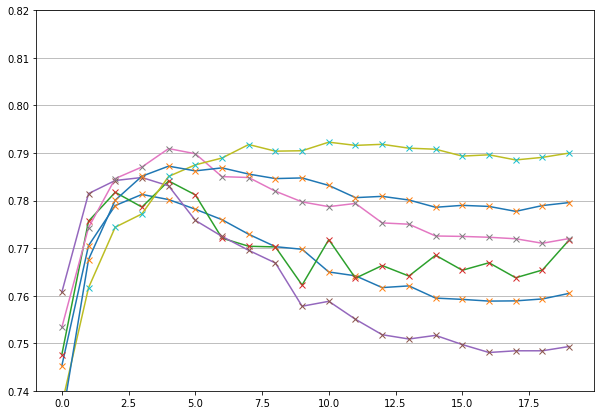

In [ ]:
HISTORIES = pickle.load(open(DCNN_dir +'HISTORIES', "rb"))

#HISTORIES[36] = {} 
#HISTORIES[36][1] = [5e-05, [],L0,[],L1]

r = len(HISTORIES)

plt.figure(figsize=(10,7))   

for i in range(r): # train_run corresponding to different hidden_dropout levels
  for j in range(1,2):  #cv_run
     #if i in [23,29,31,32,33,34,35,36] :
     if i in [39,40,41,42,43,44] :
      #plt.plot(HISTORIES[i][j][1])
      plt.plot(HISTORIES[i][j][4])
      plt.plot(HISTORIES[i][j][4],'x', label = 'learning_rate :' + str(HISTORIES[i][j][0]))  #0 is drop ratio, (1,3) is training(loss, acc) (2,4) is validation(loss,acc)

plt.ylim([0.74, 0.82])
plt.grid(axis = 'y')
#plt.legend()
plt.show()


In [ ]:
HISTORIES[45] = HISTORIES[2]

with open(DCNN_dir + "HISTORIES", "wb") as f:
  pickle.dump(HISTORIES, f)

In [ ]:
cv_run =1

In [ ]:
#@title EVALUATE ACCURACIES ON CV TEST FOLDS

SETS= pickle.load(open(DCNN_dir+'SETS', "rb"))

ACCURACIES ={}
labelS = [i for i in range(n_labels)]

iters = np.arange(0, cv_run)

for i in iters:

  model_name = NAME + '_' + 'multi' + '_' + str(i) + '.h5'

  cv = i+1
  VAL = SETS[cv][0]
  VAL_n = SETS[cv][1]
  y_VAL = SETS[cv][2]

  with strategy.scope():

    model = BERT(vocab_size = params ['vocab_size'],
                              max_seq_length = params ['max_seq_length'],
                              E_emb_dim = params['E_emb_dim'], 
                              num_attn_heads = params ['num_attn_heads'],
                              H_emb_dim_per_head = params ['H_emb_dim_per_head'] ,
                              positional = params ['positional'],
                              positional_emb_type = params ['positional_emb_type'],
                              num_layers = params ['num_layers'], 
                              shared_layers = params['shared_layers'],
                              attention_dropout = params['attention_dropout'],
                              hidden_dropout = params ['hidden_dropout'], 
                              ffn_dropout = params ['ffn_dropout'],
                              use_CLS = params['use_CLS'],
                              mode = params['mode'],
                              modeltype = params['modeltype'])
    
    model.load_weights(DCNN_dir + model_name)


  #batch_size = 1024
  #VAL = tf.data.Dataset.from_tensor_slices(VAL).batch(batch_size)
  #VAL_n = tf.data.Dataset.from_tensor_slices(VAL_n).batch(batch_size)
  y_pred = model.predict([VAL, VAL_attn, VAL_n])

  #y_pred = model.predict(VAL, batch_size = 1024)
  y_pred = y_pred.argmax(1)
  y_true = y_VAL.argmax(1)

  Cm_test = confusion_matrix(y_true, y_pred, labels=labelS )
  Cm_test = Cm_test/ np.sum(Cm_test)

  correctly_classified = np.diag(Cm_test)

  totals0 = Cm_test.sum(0)   # ty pocitas tohle  
  totals1 = Cm_test.sum(1)   # ja pocital tohle

  precision_detail =  np.divide(correctly_classified, totals0)   # ty pocitas tohle    
  recall_detail =  np.divide(correctly_classified, totals1) # ja pocital tohle

  ACCURACIES[cv] = [correctly_classified.sum(), precision_detail, recall_detail]

  try:
    del model
    gc.collect()
    print ('model deleted from ram')
  except:
    print ('no model to delete')

with open(DCNN_dir + "ACCURACIES", "wb") as f:
            pickle.dump(ACCURACIES, f)

Done loading 196 BERT weights from: drive/MyDrive/WORK/HCI/AirBank/TVT/BERT/bg_cs_pl_ru_cased_L-12_H-768_A-12_v1/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fe85fbefc90> (prefix:bert_model_layer). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
model deleted from ram


In [ ]:
#@title process ACCURACIES
ACCURACIES= pickle.load(open(DCNN_dir+'ACCURACIES', "rb"))
ACCURACIES = list(ACCURACIES.values())
ACCURACIES = pd.DataFrame(ACCURACIES)

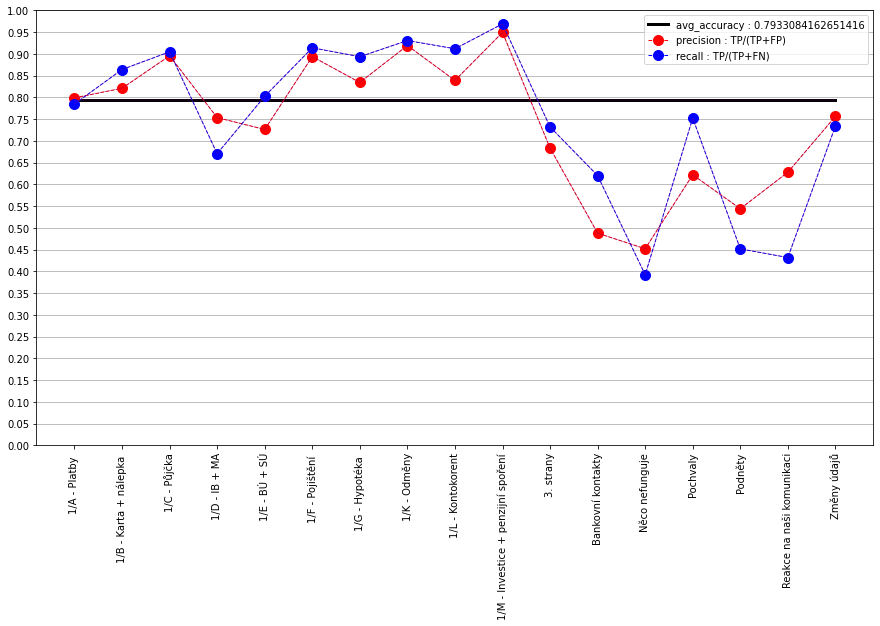

In [ ]:
#@title Plot ACCURACIES
mean_acc = ACCURACIES[0].mean(0)
mean_precision_det = ACCURACIES[1].mean(0)
mean_rec_det = ACCURACIES[2].mean(0)

encoder= pickle.load(open(DCNN_dir +'label_encoder', "rb"))
x_tick_labels = list(encoder.inverse_transform(labelS))
x_ticks = np.arange(n_labels)
y_ticks = np.arange(0, 1.05, 0.05)


plt.figure(figsize=(15,8))

avg_accuracy = np.full(n_labels, mean_acc)
plt.plot(avg_accuracy, color = 'black', linestyle='-',linewidth = 3, label = str('avg_accuracy : ' + str(mean_acc)))
plt.plot(mean_precision_det, 'bo', color = 'red', linestyle='dashed',linewidth = 1, markersize = 10, label = str('precision : TP/(TP+FP)'))
plt.plot(mean_rec_det, 'bo', color = 'blue', linestyle='dashed',linewidth = 1, markersize = 10, label = str('recall : TP/(TP+FN)'))
    
   
#individual batches    
for i , v in ACCURACIES.iterrows():
        
    avg_accuracy = np.full(n_labels, v[0])
    plt.plot(avg_accuracy, color = 'purple', linestyle='-',linewidth = 0.3)
    plt.plot(v[1], color = 'purple', linestyle='-',linewidth = 0.3)
    plt.plot(v[2], color = 'purple', linestyle='-',linewidth = 0.3)


plt.xticks(x_ticks, labels = x_tick_labels , rotation= 90)
plt.yticks(y_ticks)
plt.grid(axis='y')
plt.legend()
plt.savefig(DCNN_dir + 'CV_accuracies.png')
plt.show()
    

In [ ]:
def scorePRIMARY(data_set, NAME, params = params_multi, cv_run = 1):
  
  # data is in the form (data[0], data[1]), where data[0] are the input_ids and data[1] are the numerical inputs

  data = data_set.copy()
    
  df_predprob = np.zeros([data[0].shape[0], n_labels])
    
  for i in range(max(cv_run,1)):

    model_name = NAME + '_' + 'multi' + '_' + str(i) + '.h5'

    print(model_name)

    with strategy.scope():
      
      model = BERT(vocab_size = params ['vocab_size'],
                              max_seq_length = params ['max_seq_length'],
                              E_emb_dim = params['E_emb_dim'], 
                              num_attn_heads = params ['num_attn_heads'],
                              H_emb_dim_per_head = params ['H_emb_dim_per_head'] ,
                              positional = params ['positional'],
                              positional_emb_type = params ['positional_emb_type'],
                              num_layers = params ['num_layers'], 
                              shared_layers = params['shared_layers'],
                              attention_dropout = params['attention_dropout'],
                              hidden_dropout = params ['hidden_dropout'], 
                              ffn_dropout = params ['ffn_dropout'],
                              use_CLS = params['use_CLS'],
                              mode = params['mode'],
                              modeltype = params['modeltype'])
    
    model.load_weights(DCNN_dir + model_name)

    df_predprob += model.predict([data[0], data[1]])
    
  return df_predprob/max(cv_run,1)

In [ ]:
typ = 'test'

if typ == 'train' :
    df_predprob = scorePRIMARY([train_set, train_numeric], NAME)
    y_true = train_labels.argmax(1)

if typ == 'test':
    df_predprob = scorePRIMARY([test_set,test_numeric], NAME)
    y_true = test_labels.argmax(1)

print(df_predprob)

print('\n')

print(df_predprob.sum(1))

ALBERT_L0_multi_0.h5
Done loading 196 BERT weights from: drive/MyDrive/WORK/HCI/AirBank/TVT/BERT/bg_cs_pl_ru_cased_L-12_H-768_A-12_v1/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fe8618987d0> (prefix:bert_model_layer_1). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
[[2.48799653e-04 2.96606740e-05 7.10921886e-05 ... 2.77580784e-06
  4.54598194e-05 4.16389685e-06]
 [1.68092640e-06 1.92996493e-04 7.75269837e-06 ... 4.36365042e-07
  7.41998374e-05 9.99594867e-01]
 [2.24318810e-05 1.01809201e-06 9.08324582e-05 ... 3.83281844e-07
  2.30387991e-0

In [ ]:
y_true_backup = y_true

In [ ]:
MIX_predprob = df_predprob
y_true = y_true_backup

PD_THRESHOLD = 0

Z = zip(y_true, MIX_predprob)
tuples = [(i,j)  for i, j in Z if max(j) > PD_THRESHOLD ]
tuples = zip(*tuples)
y_true, MIX_predprob = [ list(tuple)  for tuple in tuples ]
y_true = pd.Series(y_true)
MIX_predprob = np.array(MIX_predprob)

print(len(y_true)/len(test_labels))

1.0


In [ ]:
import math

def top_k(L, k):  
    
    #L is the probability vector 
    #k is the order of top
    
    A = [i for i in range(n_labels)]

    top_logOdds = [math.log( tuple[0] / (1-tuple[0]) ) for tuple in sorted(zip(L,A), reverse = True)][0:k]
    
    _top_k = [tuple[1] for tuple in sorted(zip(L,A), reverse = True)][0:k]
    
    top_k = [_top_k[0]]
   
    if k > 1:
        
        for j in range(1, max(k,2)):
            if top_logOdds[j] > 2*top_logOdds[0]:   #negative numbers
                top_k.append(_top_k[j]) 
    
    #return _top_k
    return top_k

In [ ]:
#MIX_predprob_F = MIX_predprob[maskACCEPT]
#y_true_F = y_true[maskACCEPT]

MIX_predprob_F = MIX_predprob
y_true_F = y_true

In [ ]:
#[]
#encoder = preprocessing.LabelEncoder()
#y = encoder.fit_transform(train['LEVEL_2'])

encoder= pickle.load(open(DCNN_dir +'label_encoder', "rb"))
y = encoder.transform(train['LEVEL_2'])

ERRORS = []

#[]

mismatch = {}
for value in set(y_true_F.values):  #{0,...17}
    
    mismatch[value] = [0, y_true_F.value_counts()[value],1,0]

#[]

K = 1
index = 0
CLASSIFICATION = []

for vec in MIX_predprob_F: #vector with n_labels values
    
    choices = top_k(vec,K)
    CLASSIFICATION.append(encoder.inverse_transform(choices))
    
    #print(choices)
    
    k = y_true_F.values[index]
    
    if k not in choices:
        mismatch[k][0]+=1
        ERRORS.append([index, k, choices[0], vec.max()])
    else:
        pass     
    index+=1
    

CLASSIFICATION = np.array(CLASSIFICATION, dtype=object)
if K ==1:
    CLASSIFICATION = CLASSIFICATION.flatten()
    
    
#[]

for key in mismatch.keys():
    mismatch[key][3]  = round(100*mismatch[key][0]/mismatch[key][1],0)
    
#[]
mismatch = pd.DataFrame(mismatch).T
mismatch = mismatch.reset_index(drop = False)
mismatch.rename(columns = {'index': 'label' ,0: 'incorrect', 1: 'total', 2: 'WT', 3: 'ratio'}, inplace = True)

print('error rates (' + typ + ') :')

mismatch['label_desc'] = mismatch['label'].apply(lambda x: encoder.inverse_transform([x])[0]  )

display(mismatch)

#[]
N_incorrect = np.multiply(mismatch['incorrect'],mismatch['WT']).values.sum()
N  = np.multiply(mismatch['total'],mismatch['WT']).values.sum()

overall_error_rate = N_incorrect/N

print('overall_accuracy_rate:' , 1-overall_error_rate)

#with open(PATH_LSTM + "MISMATCH", "wb") as f:
#            pickle.dump(mismatch , f) 

ERRORS = pd.DataFrame(ERRORS)
ERRORS.rename(columns = {0:'data_index', 1 : 'actual', 2 : 'pred', 3: 'pd_pred'}, inplace = True)

display(ERRORS)

mismatch.to_csv(DCNN_dir + 'mismatch.csv' , encoding='utf-8')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


error rates (test) :


,label,incorrect,total,WT,ratio,label_desc
0,0,792.0,3345.0,1.0,24.0,1/A - Platby
1,1,924.0,6731.0,1.0,14.0,1/B - Karta + nálepka
2,2,349.0,3529.0,1.0,10.0,1/C - Půjčka
3,3,643.0,1992.0,1.0,32.0,1/D - IB + MA
4,4,915.0,4352.0,1.0,21.0,1/E - BÚ + SÚ
5,5,56.0,587.0,1.0,10.0,1/F - Pojištění
6,6,38.0,413.0,1.0,9.0,1/G - Hypotéka
7,7,68.0,743.0,1.0,9.0,1/K - Odměny
8,8,94.0,1011.0,1.0,9.0,1/L - Kontokorent
9,9,46.0,1333.0,1.0,3.0,1/M - Investice + penzijní spoření


overall_accuracy_rate: 0.7863215632499143


,data_index,actual,pred,pd_pred
0,6,1,16,0.977154
1,13,4,1,0.986408
2,28,16,1,0.774034
3,36,15,4,0.907516
4,43,0,1,0.646284
...,...,...,...,...
6228,29153,2,0,0.431348
6229,29156,4,3,0.997847
6230,29157,4,0,0.934488
6231,29164,1,11,0.727255


In [ ]:
mismatch['total'].sum()

29170.0

**OUTPUT**

In [ ]:
try:
    if CLASSIFICATION.shape[1] > 1 :
        G =[list(i) for i  in CLASSIFICATION]
        
except:
    G = CLASSIFICATION
    
if typ == 'train' :
    D = train.iloc[maskACCEPT]   
    D = D.reset_index(drop = True)
    OUT_DATA = pd.concat([D, pd.Series(G)], axis =1)
    
if typ == 'valid' :
    D = valid.iloc[maskACCEPT]   
    D = D.reset_index(drop = True)
    OUT_DATA = pd.concat([D, pd.Series(G)], axis =1)
    
if typ == 'test' :
    D = test  
    D = D.reset_index(drop = True)
    OUT_DATA = pd.concat([D, pd.Series(G)], axis =1)
    
OUT_DATA.rename(columns = {0: 'Klasifikace_modelem'}, inplace = True)
OUT_DATA.drop(columns =['LEVEL_2_ENCODED'], inplace = True)
OUT_DATA['shoda'] = OUT_DATA.apply(lambda row : 1  if row['LEVEL_2'] in row['Klasifikace_modelem'] else 0, axis =1)
OUT_DATA['nasobnost_klasifikace'] = OUT_DATA['Klasifikace_modelem']\
                                        .apply(lambda x : 0 if len(x) == 1 else 1)
OUT_DATA['omni'] = 1
display(OUT_DATA)
OUT_DATA.to_csv(DCNN_dir + 'out_data.csv' , encoding='utf-8')

,SKP_CONTACT,LEVEL_2,PREDMET_CLEAN,TEXT_KOMUNIKACE_CLEAN,JOINT_CLEAN,tokens_joint,len_PREDMET,len_TEXT,EMAIL,WT,len_PREDMET_s,len_TEXT_s,Klasifikace_modelem,shoda,nasobnost_klasifikace,omni
0,177076925,1/F - Pojištění,,na mém účtu dochází k placení pojistného pojiš...,na mém účtu dochází k placení pojistného poji...,"[na, mém, účtu, dochází, k, placení, pojistnéh...",0,28,1,1,-1.205958,-0.512533,1/F - Pojištění,1,1,1
1,177086184,Změny údajů,Změna jména,vdala jsem se a mám jiné přijmení je potřeba c...,Změna jména vdala jsem se a mám jiné přijmení ...,"[Změna, jména, vdala, jsem, se, a, mám, jiné, ...",2,17,0,1,-0.689260,-0.759066,Změny údajů,1,1,1
2,177210323,1/G - Hypotéka,Hypotéka dotaz,měla bych dotaz ohledně žádosti o hypotéku Vím...,Hypotéka dotaz měla bych dotaz ohledně žádosti...,"[Hypotéka, dotaz, měla, bych, dotaz, ohledně, ...",2,50,1,1,-0.689260,-0.019467,1/G - Hypotéka,1,1,1
3,177238356,1/E - BÚ + SÚ,Re Zalozeni uctu,aplikaci my air to nejde Nepustilo mne to z du...,Re Zalozeni uctu aplikaci my air to nejde Nepu...,"[Re, Zalozeni, uctu, aplikaci, my, air, to, ne...",3,136,1,1,-0.430910,1.907973,1/E - BÚ + SÚ,1,1,1
4,177306864,1/B - Karta + nálepka,Re Platba,děkuji za vyřízení už vím kde problém Je to an...,Re Platba děkuji za vyřízení už vím kde problé...,"[Re, Platba, děkuji, za, vyřízení, už, vím, kd...",2,51,0,1,-0.689260,0.002945,1/B - Karta + nálepka,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29165,214462900,1/E - BÚ + SÚ,Re Úročení spořicího účtu,Takže když spořicí účet logicky používám pouze...,Re Úročení spořicího účtu Takže když spořicí ú...,"[Re, Úročení, spořicího, účtu, Takže, když, sp...",4,33,0,1,-0.172561,-0.400473,1/E - BÚ + SÚ,1,1,1
29166,214499646,1/K - Odměny,nákup,v pátek listopadu jsem v Albertu nakoupil za a...,nákup v pátek listopadu jsem v Albertu nakoupi...,"[nákup, v, pátek, listopadu, jsem, v, Albertu,...",1,27,0,1,-0.947609,-0.534945,1/K - Odměny,1,1,1
29167,214787559,1/B - Karta + nálepka,Fwd Storno,Přeposílám vám email od sazky Lazaridisova Pův...,Fwd Storno Přeposílám vám email od sazky Lazar...,"[Fwd, Storno, Přeposílám, vám, email, od, sazk...",2,43,1,1,-0.689260,-0.176352,1/A - Platby,0,1,1
29168,214921617,1/C - Půjčka,Úvěr ve výši storno,Vzhledem k situaci bych ráda zrušila svoji zad...,Úvěr ve výši storno Vzhledem k situaci bych rá...,"[Úvěr, ve, výši, storno, Vzhledem, k, situaci,...",4,12,0,1,-0.172561,-0.871126,1/C - Půjčka,1,1,1


**stats**

1    29170
Name: nasobnost_klasifikace, dtype: int64


LEVEL_2
1/A - Platby                          0.763229
1/B - Karta + nálepka                 0.862725
1/C - Půjčka                          0.901105
1/D - IB + MA                         0.677209
1/E - BÚ + SÚ                         0.789752
1/F - Pojištění                       0.904600
1/G - Hypotéka                        0.907990
1/K - Odměny                          0.908479
1/L - Kontokorent                     0.907023
1/M - Investice + penzijní spoření    0.965491
3. strany                             0.684685
Bankovní kontakty                     0.643275
Něco nefunguje                        0.354717
Pochvaly                              0.802920
Podněty                               0.447289
Reakce na naši komunikaci             0.419129
Změny údajů                           0.730632
dtype: float64


LEVEL_2
1/A - Platby                          0.114673
1/B - Karta + nálepka                 0.230751
1/C - Půjčka       

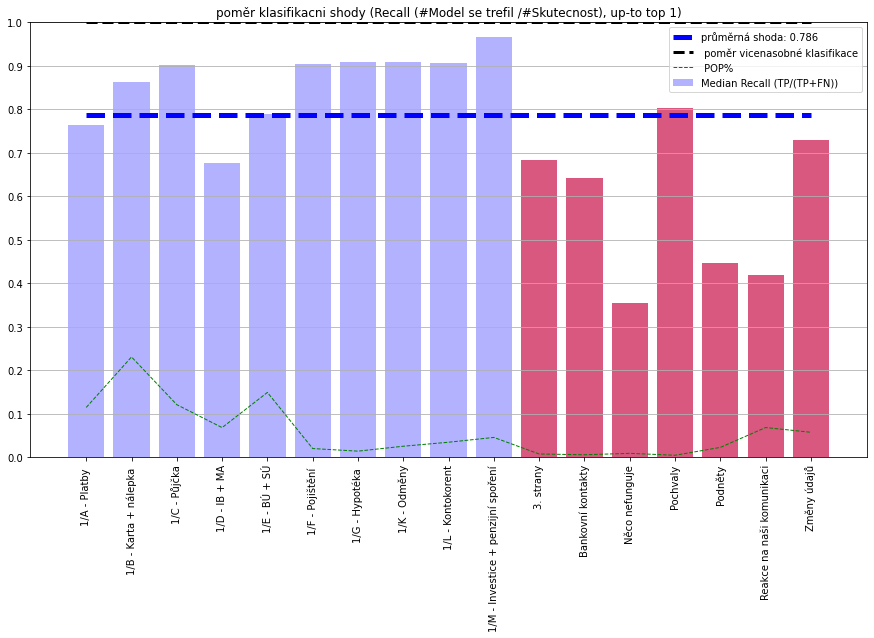

In [ ]:
procenta_shody= OUT_DATA.groupby(['LEVEL_2'], sort = True).apply(lambda dfx: dfx['shoda'].mean() ) 
pop= OUT_DATA.groupby(['LEVEL_2'], sort = True).apply(lambda dfx: dfx['omni'].sum() ) / OUT_DATA.shape[0]

procenta_shody_problematic = procenta_shody.copy()
for i in range(n_labels):
    if i not in [10, 11,12,13,14,15,16]:
        procenta_shody_problematic[i] = 0       

nasobnost = OUT_DATA.groupby(['LEVEL_2'], sort = True).apply(lambda dfx: dfx['nasobnost_klasifikace'].mean())

celkova_shoda = OUT_DATA['shoda'].mean() ; celkova_shoda = np.full(n_labels, celkova_shoda)

print(OUT_DATA['nasobnost_klasifikace'].value_counts())
print('\n')
print(procenta_shody)
print('\n')
avg_shoda = '%0.3f' % (celkova_shoda.mean())
print(pop)


plt.figure(figsize=(15,8))
plt.title ('poměr klasifikacni shody (Recall (#Model se trefil /#Skutecnost), up-to top 1)')
plt.bar( procenta_shody.index , procenta_shody.values, color = 'blue', alpha = 0.3 , label = 'Median Recall (TP/(TP+FN))')
plt.bar( procenta_shody_problematic.index , procenta_shody_problematic.values, color = 'red',  alpha = 0.5)
plt.plot(celkova_shoda, color = 'blue', linestyle='dashed',linewidth = 5, label = 'průměrná shoda: ' + avg_shoda )
plt.plot(nasobnost, color = 'black', linestyle='dashed',linewidth = 3, label = ' poměr vicenasobné klasifikace' )
plt.plot(pop, color = 'green', linestyle='dashed',linewidth = 1, label = ' POP%' )
plt.ylim([0,1])
y_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(y_ticks)
plt.xticks(rotation= 90)
plt.legend()
plt.grid(axis='y')
plt.savefig(DCNN_dir + 'klasifikace.png')
plt.show()

## Accuracy, Precision and Recall

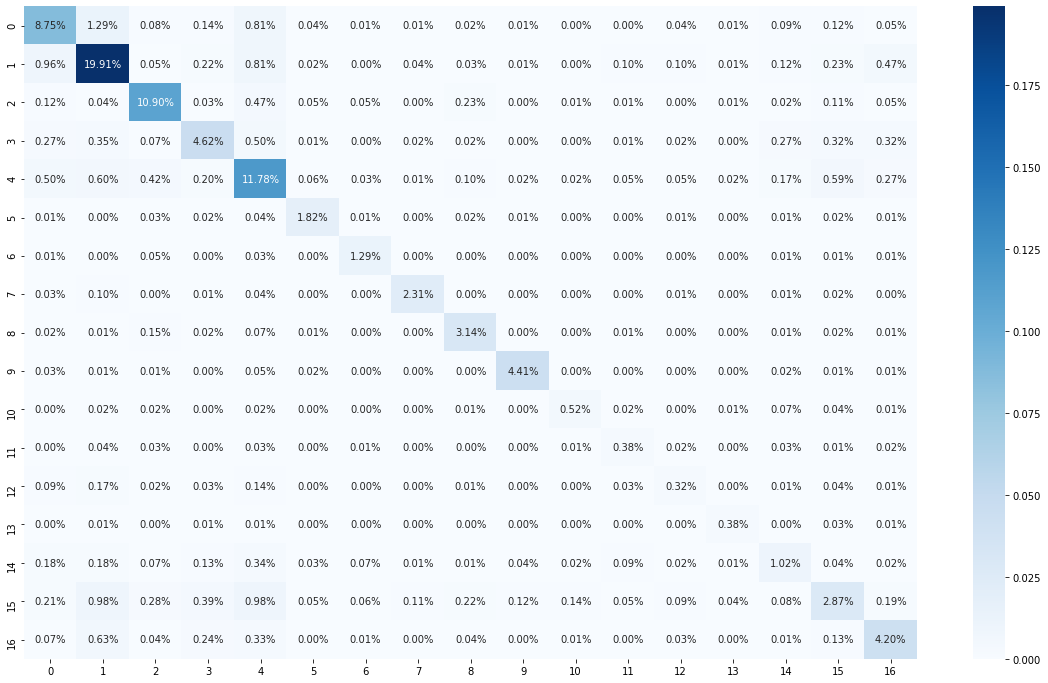

In [ ]:
y_pred_F = MIX_predprob_F.argmax(1)

labelS = [i for i in range(n_labels)]

Cm_test = confusion_matrix(y_true_F, y_pred_F, labels=labelS )
Cm_test = Cm_test/ np.sum(Cm_test)

pd.DataFrame(Cm_test).to_csv(DCNN_dir  + 'Cm_test.csv' , encoding='utf-8')

#print(Cm_test.sum(1))
#print (Cm_test[0][1:].sum())

plt.figure(figsize = (20,12))
sns.heatmap(Cm_test, annot = True, fmt = ".2%", cmap = "Blues")
plt.savefig(DCNN_dir + 'CM.png')

**Bootstrap**

In [ ]:
RES = pd.DataFrame([y_pred_F, y_true_F]).T
RES.rename(columns = {0 : 'y_pred', 1 : 'y_true'}, inplace = True)

labelS = [i for i in range(17)]

n = RES.shape[0]

G0 = pd.DataFrame()
G1p = pd.DataFrame()
G1r = pd.DataFrame()

np.random.seed(seed = 42) 

for i in range(0,1000):

    mask = np.random.randint(n, size=n)
    BTSTRP = RES.loc[mask]

    confusion_matrix_test = confusion_matrix(BTSTRP['y_true'], BTSTRP['y_pred'], labels=labelS )
    confusion_matrix_test = confusion_matrix_test/ np.sum(confusion_matrix_test)

    correctly_classified = np.diag(confusion_matrix_test)  #TP
    avg_accuracy = np.full(17,correctly_classified.sum())
    
    totals = confusion_matrix_test.sum(0)  # TP + FP
    precision =  np.divide(correctly_classified, totals)
    
    totals = confusion_matrix_test.sum(1)  # TP +FN
    recall =  np.divide(correctly_classified, totals)
    
    G0 = G0.append(pd.Series(avg_accuracy), ignore_index=True)
    G1p = G1p.append(pd.Series(precision), ignore_index=True)
    G1r = G1r.append(pd.Series(recall), ignore_index=True)

#display(G1)    

#Overall accuracy    
#-----------------

LB = np.percentile(G0, 1, axis=0)
#median = np.percentile(G1, 50, axis=0)
median = G0.mean(0)
UB = np.percentile(G0, 99, axis=0)

G2_0 = pd.DataFrame([LB,median,UB]).T
G2_0.rename(columns = {0 : '1pct', 1: 'median', 2 : '99pct'}, inplace = True)

G2_0['label'] = encoder.inverse_transform(G2_0.index)
G2_0.to_csv(DCNN_dir  + 'avg_accuracy_BTSRP.csv' , encoding='utf-8')


#Precision:
#----------

LB = np.percentile(G1p, 1, axis=0)
#median = np.percentile(G1, 50, axis=0)
median = G1p.mean(0)
UB = np.percentile(G1p, 99, axis=0)

G2_1 = pd.DataFrame([LB,median,UB]).T
G2_1.rename(columns = {0 : '1pct', 1: 'median', 2 : '99pct'}, inplace = True)

G2_1['label'] = encoder.inverse_transform(G2_1.index)
G2_1.to_csv(DCNN_dir  + 'avg_accuracy_BTSRP.csv' , encoding='utf-8')

#Recall
#-----------
LB = np.percentile(G1r, 1, axis=0)
#median = np.percentile(G1, 50, axis=0)
median = G1r.mean(0)
UB = np.percentile(G1r, 99, axis=0)

G2_2 = pd.DataFrame([LB,median,UB]).T
G2_2.rename(columns = {0 : '1pct', 1: 'median', 2 : '99pct'}, inplace = True)

G2_2['label'] = encoder.inverse_transform(G2_2.index)
G2_2.to_csv(DCNN_dir  + 'avg_accuracy_BTSRP.csv' , encoding='utf-8')

In [ ]:
display(G2_0)
display(G2_1)
display(G2_2)

,1pct,median,99pct,label
0,0.780973,0.786579,0.791978,1/A - Platby
1,0.780973,0.786579,0.791978,1/B - Karta + nálepka
2,0.780973,0.786579,0.791978,1/C - Půjčka
3,0.780973,0.786579,0.791978,1/D - IB + MA
4,0.780973,0.786579,0.791978,1/E - BÚ + SÚ
5,0.780973,0.786579,0.791978,1/F - Pojištění
6,0.780973,0.786579,0.791978,1/G - Hypotéka
7,0.780973,0.786579,0.791978,1/K - Odměny
8,0.780973,0.786579,0.791978,1/L - Kontokorent
9,0.780973,0.786579,0.791978,1/M - Investice + penzijní spoření


,1pct,median,99pct,label
0,0.759287,0.777153,0.794086,1/A - Platby
1,0.808640,0.818283,0.828777,1/B - Karta + nálepka
2,0.879110,0.891622,0.904141,1/C - Půjčka
3,0.739777,0.762478,0.784990,1/D - IB + MA
4,0.701464,0.716413,0.730354,1/E - BÚ + SÚ
5,0.829425,0.862983,0.893988,1/F - Pojištění
6,0.797915,0.836349,0.875274,1/G - Hypotéka
7,0.887554,0.914513,0.937417,1/K - Odměny
8,0.786323,0.812907,0.840578,1/L - Kontokorent
9,0.940013,0.952660,0.964982,1/M - Investice + penzijní spoření


,1pct,median,99pct,label
0,0.746315,0.763630,0.780479,1/A - Platby
1,0.853109,0.862969,0.873441,1/B - Karta + nálepka
2,0.889169,0.901071,0.912462,1/C - Půjčka
3,0.654505,0.677558,0.701374,1/D - IB + MA
4,0.776025,0.790091,0.804116,1/E - BÚ + SÚ
5,0.875639,0.904740,0.931039,1/F - Pojištění
6,0.874690,0.907855,0.938917,1/G - Hypotéka
7,0.881307,0.908713,0.932292,1/K - Odměny
8,0.885887,0.907359,0.927117,1/L - Kontokorent
9,0.952450,0.965322,0.976762,1/M - Investice + penzijní spoření


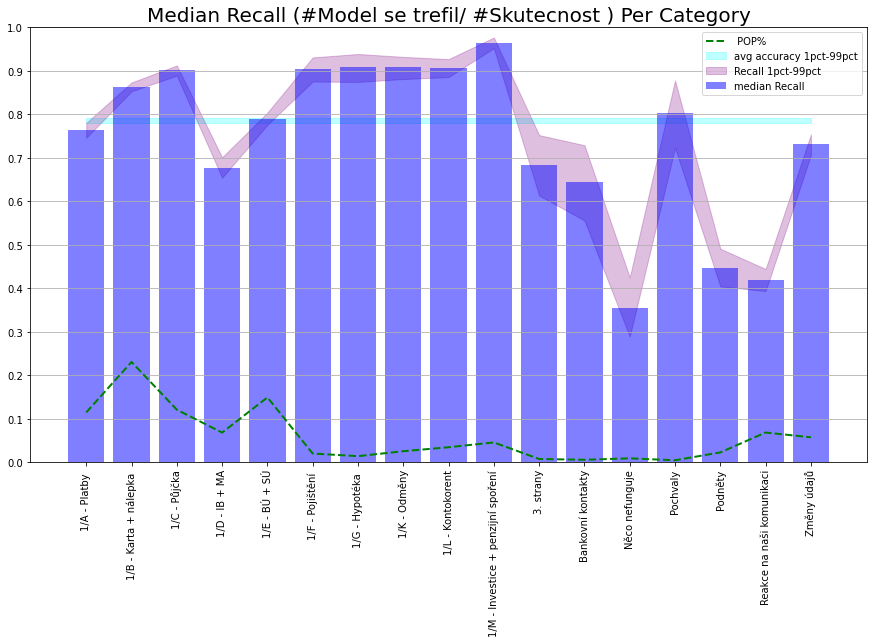

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Median Recall (#Model se trefil/ #Skutecnost ) Per Category', fontsize = 20)
plt.bar(G2_2['label'] , G2_2['median'].values, color = 'blue', alpha = 0.5, label= 'median Recall')
plt.fill_between(G2_0['label'], G2_0['1pct'], G2_0['99pct'], alpha = 0.25,  color = 'cyan', label= 'avg accuracy 1pct-99pct')
plt.fill_between(G2_2['label'], G2_2['1pct'], G2_2['99pct'], alpha = 0.25,  color = 'purple', label= 'Recall 1pct-99pct')
plt.plot(pop, color = 'green', linestyle='dashed',linewidth = 2, label = ' POP%' )
plt.ylim([0,1])
x_ticks =  procenta_shody.index
y_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(y_ticks)
plt.xticks(rotation= 90)
plt.legend()
plt.grid(axis='y')
plt.savefig(DCNN_dir + 'Recall.png')
plt.show()

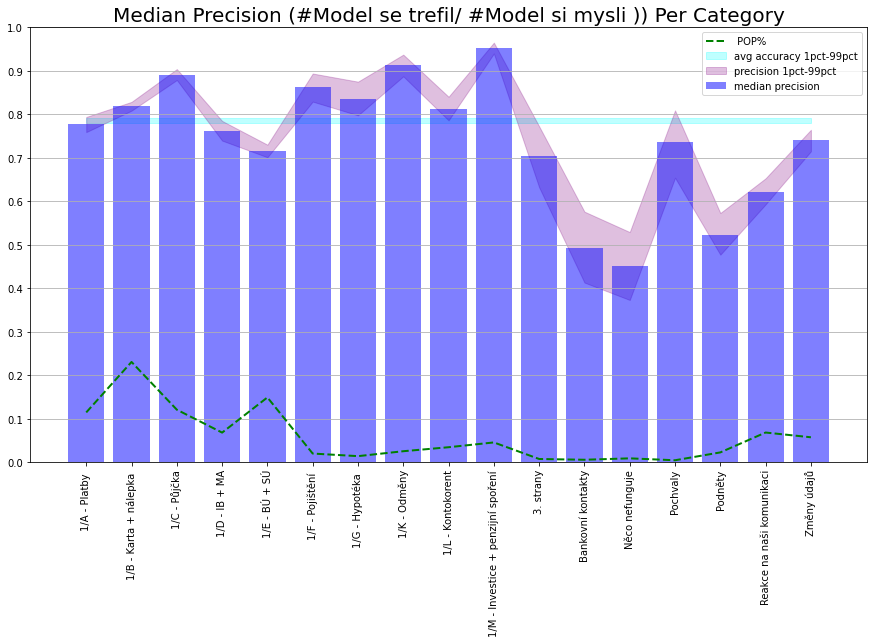

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Median Precision (#Model se trefil/ #Model si mysli )) Per Category', fontsize = 20)
plt.bar(G2_1['label'] , G2_1['median'].values, color = 'blue', alpha = 0.5, label= 'median precision')
plt.fill_between(G2_0['label'], G2_0['1pct'], G2_0['99pct'], alpha = 0.25,  color = 'cyan', label= 'avg accuracy 1pct-99pct')
plt.fill_between(G2_1['label'], G2_1['1pct'], G2_1['99pct'], alpha = 0.25,  color = 'purple', label= 'precision 1pct-99pct')
plt.plot(pop, color = 'green', linestyle='dashed',linewidth = 2, label = ' POP%' )
plt.ylim([0,1])
x_ticks =  procenta_shody.index
y_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(y_ticks)
plt.xticks(rotation= 90)
plt.legend()
plt.grid(axis='y')
plt.savefig(DCNN_dir + 'precision.png')
plt.show()

In [ ]:
https://stackoverflow.com/questions/61137759/valueerror-cannot-reshape-a-tensor-bert-transfer-learning
https://www.kaggle.com/sriharihumbarwadi/fine-tuning-bert-on-tpu